## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
!nvidia-smi

Tue Mar  8 04:56:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
from tensorflow import keras

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
train, test = keras.datasets.cifar10.load_data()

In [4]:
# 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preproc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
from keras.regularizers import l2
from keras.layers import Dropout, BatchNormalization

def build_mlp(input_shape, 
              output_units=10, 
              num_neurons=[512, 256, 128], 
              regularizer=True, 
              dropout=True,
              batchnorm=True):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            if regularizer:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu",  
                                       kernel_regularizer=l2(1e-4))(input_layer)
            else:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu")(input_layer)
            if batchnorm:
                x = BatchNormalization()(x)
            if dropout:
                x = Dropout(0.2)(x)
        else:
            if regularizer:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu",
                                       kernel_regularizer=l2(1e-4))(x)
            else:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu")(x)
            if batchnorm:
                x = BatchNormalization()(x)
            if dropout:
                x = Dropout(0.2)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

model = build_mlp(input_shape=x_train.shape[1:])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 dense (Dense)               (None, 512)               1573376   
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                             

In [7]:
# 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
REGULARIZER = [False, True]
DROPOUT = [False, True]
BATCHNORM = [False, True]

def NAMETAG(reg, drp, bn):
    if reg:
        tag = "L2(1e-4)"
    else:
        tag = ""
    if drp:
        if len(tag) != 0:
            tag += " + Dropout(0.2)"
        else:
            tag = "Dropout(0.2)"
    if bn:
        if len(tag) != 0:
            tag += " + BatchNorm"
        else:
            tag = "BatchNorm"
    if len(tag) == 0:
        return "Original"
    else:
        return tag

In [8]:
results = {}

for reg in REGULARIZER:
    for drp in DROPOUT:
        for bn in BATCHNORM:
            keras.backend.clear_session() # 把舊的 Graph 清掉
            
            exp_name_tag = NAMETAG(reg, drp, bn)

            print(f"Experiment: {exp_name_tag}")

            model = build_mlp(input_shape=x_train.shape[1:], regularizer=reg, dropout=drp, batchnorm=bn)

            optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
            model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

            history = model.fit(x_train, y_train, 
                                epochs=EPOCHS, 
                                batch_size=BATCH_SIZE, 
                                validation_data=(x_test, y_test), 
                                shuffle=True, 
                                verbose=0)

            # Collect results
            train_loss = model.history.history["loss"]
            valid_loss = model.history.history["val_loss"]
            train_acc = model.history.history["accuracy"]
            valid_acc = model.history.history["val_accuracy"]

            results[exp_name_tag] = {'train-loss': train_loss,
                                     'valid-loss': valid_loss,
                                     'train-acc': train_acc,
                                     'valid-acc': valid_acc}

Experiment: Original
Experiment: BatchNorm
Experiment: Dropout(0.2)
Experiment: Dropout(0.2) + BatchNorm
Experiment: L2(1e-4)
Experiment: L2(1e-4) + BatchNorm
Experiment: L2(1e-4) + Dropout(0.2)
Experiment: L2(1e-4) + Dropout(0.2) + BatchNorm


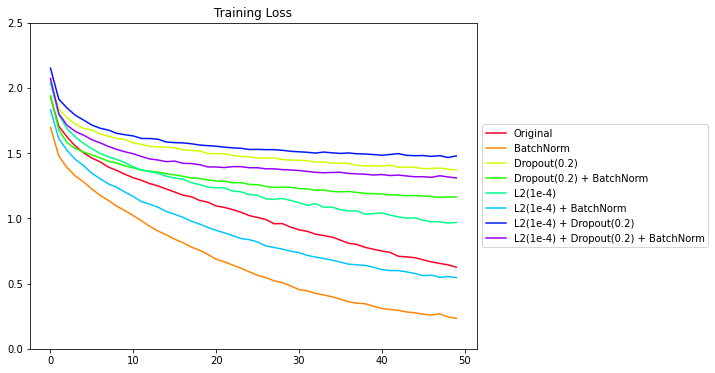

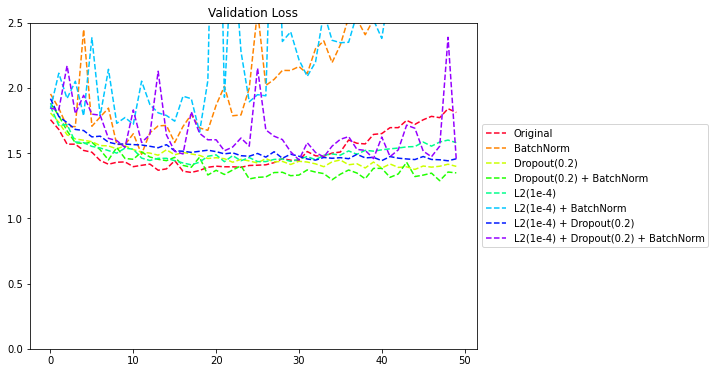

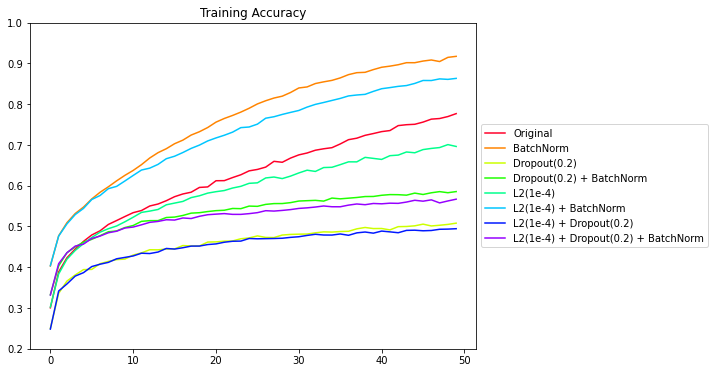

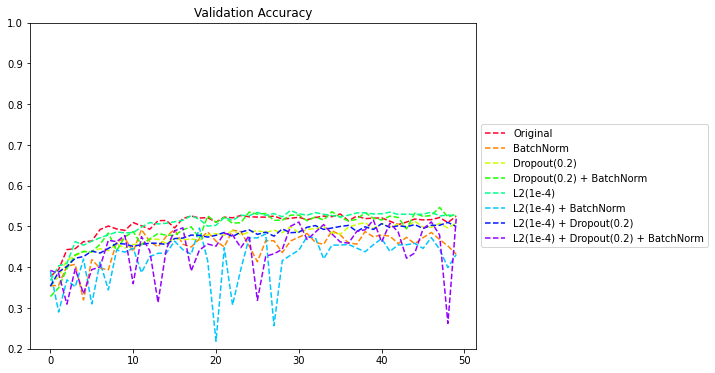

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

plt.figure(figsize=(8, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])), results[cond]['train-loss'], 
             '-', label=cond, color=color_bar[i])
plt.title("Training Loss")
plt.ylim([0, 2.5])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['valid-loss'])), results[cond]['valid-loss'], 
             '--', label=cond, color=color_bar[i])
plt.title("Validation Loss")
plt.ylim([0, 2.5])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])), results[cond]['train-acc'], 
             '-', label=cond, color=color_bar[i])
plt.title("Training Accuracy")
plt.ylim([0.2, 1])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], 
             '--', label=cond, color=color_bar[i])
plt.title("Validation Accuracy")
plt.ylim([0.2, 1])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()